In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels


scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro':'f1_macro'}

title = 'feature166_testsize0.3'
KFOLD = 10
N_JOBS = 10

def preprocess(countpath, testsize = 0.2):
    x = pd.read_csv('%s' % countpath, index_col=0).T

    # get feature names
    featurenames = np.array(x.index)

    # get label names
    x = x.T
    y = list(np.array(x.index))
    label = sorted(list(set(y)), key = y.index)
    
    df = x
    df['target'] = y

    for classname in label:
        count_temp = len(df[df.target == classname])
        print("Proportion of family {0}: {1:.2f}%".format(classname, (count_temp / (len(df.target)) * 100)))


    y = df.target.values
    x= df.drop(['target'], axis=1)
    
#     x = x.drop(['A', 'C', 'G', 'U'], axis = 1)
    x = (x - np.min(x)) / (np.max(x) - np.min(x)).values
    
    # Normalize
#     x= x.apply(lambda x :(x-np.min(x))/(np.max(x)-np.min(x)))
    
    x = x.dropna(axis=1, how='any')  # drop all rows that have any NaN value
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = testsize, random_state = 1)

    return x_train, y_train, x_test, y_test, featurenames, label, df

def heat_norm_col(label, featurenames, x_train, counting):
    heat = pd.DataFrame(0, index=np.arange(len(label)), columns=np.arange(featurenames.size))
    heat.index = label
    heat.columns = featurenames
    for i in range(0, len(x_train.index)):
        for j in range(0, len(x_train.columns)):
            heat.loc[x_train.index[i], x_train.columns[j]] = heat.loc[x_train.index[i], x_train.columns[j]] + x_train.iloc[i, j]


    heat_norm = heat
    for i in range(0, len(heat_norm.index)):
        for j in range(0, len(heat_norm.columns)):
            heat_norm.iloc[i, j] = heat_norm.iloc[i, j] / counting[heat_norm.index[i]]

    fig, ax = plt.subplots(figsize=(10,15), dpi = 220)         # Sample figsize in inches
    # Now if we normalize it by column:
    heat_norm_col = heat_norm
    heat_norm_col=(heat_norm_col-heat_norm_col.mean())/heat_norm_col.std()

    return heat_norm_col

def plot_conusion_matrix(model,balance = 'balanced', cmap = plt.cm.Blues, normalize = True):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    confusion = confusion_matrix(y_test, pred)

    ax = plot_con_matrix(confusion, label, normalize=normalize, title = 'Confusion matrix, with normalization of %s %s' % (balance, model) , cmap = cmap)

    plt.show()
    plt.savefig('./Prediction_output_%s/confusion_matrix_%s.png' % (title, model), format='png')


def plot_feature_distribution_heatmap(heat_norm_col,label, cmp = plt.cm.Blues):
    
    ax = plot_con_matrix(heat_norm_col.T, label, normalize = False, title = 'Normalized feature distribution of every family', cmap = cmp)
    plt.show()
    plt.savefig('./Prediction_output_%s/feature_distribution_%s.png' % (title, model), format='png')

    
def plot_con_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    SMALL_SIZE = 9
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 19

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
    
    fig, ax = plt.subplots(figsize = (16, 12), dpi = 330)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
          )
    
    fig.suptitle('%s' % title, fontsize=BIGGER_SIZE)    
    plt.xlabel('Predicted Family', fontsize=MEDIUM_SIZE)
    plt.ylabel('True Family', fontsize=MEDIUM_SIZE)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Adjust the space between ticks and label
    ax.tick_params(axis='both', which='major', pad=5)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0.01:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return ax


def counting(label, y_train):
    counting = {}
    for i in label:
        count = 0
        for j in y_train:
            if i == j:
                count = count+1        
        counting[i] = count
    print(counting)
    
    return counting


def smote_dict(label, counting):
    dict = {}
    for i in label:
        if counting[i] > 1000:
            dict[i] = counting[i]
        elif counting[i] > 700:
            dict[i] = counting[i] * 2
        elif counting[i] > 500:
            dict[i] = counting[i] * 3
        elif counting[i] > 200:
            dict[i] = counting[i] * 5
        else:
            dict[i] = counting[i] * 10
    print(dict)
    return dict


def calcu_metrix(scores):
    return (np.mean(scores['test_f1_macro']) * 0.6 + np.mean(scores['test_prec_macro'])*0.2 + np.mean(scores['test_rec_macro'])* 0.2)


def print_report(name, model, x_test, y_test):
    
    model_pred = model.predict(x_test)
    
    # f1 score
    print("f1 score of {0}: {1:.3f}".format(name, f1_score(y_test,model_pred, average = 'macro')))
    # 模型评估报告
    report = classification_report(y_test, model_pred, target_names= label, output_dict=True)
    
    dataframe = pd.DataFrame(report).transpose()
    dataframe.to_csv('./Prediction_output_%s/Classification_report/%s_%s.csv' % (title, title, name), index = False)

    print("Classification report of {0}: \n{1}".format(name, classification_report(y_test, model_pred,
                                            target_names= label, digits = 3)))


def pltROC(knn, svm, random, boost, mlp, nb, x_train, y_trian, x_test, y_test, balance = 'balanced'):

    knn.fit(x_train, y_train)
    svm.fit(x_train, y_train)
    nb.fit(x_train, y_train)
    boost.fit(x_train, y_train)
    random.fit(x_train, y_train)
    mlp.fit(x_train, y_train)

    d = {knn: 'KNN', svm: 'SVM', nb: 'Naive_Bayes', boost: 'Gradient-boosting', random: 'Random forest', mlp:'Neural Network'}
    # model.predict_proba(x_test)[:,1]
    # y_test.values
    plt.figure(figsize=(24, 16))
    fig, ax = plt.subplots()
    # ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".4")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 10
    plt.title('ROC curve for cancer classifier with the feature selecting \nmethod of %s' % c[count])
    # plt.subplots_adjust(wspace=2, hspace=1, top = 1)
    plt.xlabel("FPR")
    plt.ylabel("TPR(recall)")
    plt.grid(True)
    for model in d:
        proba_rf = model.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, proba_rf)
        close_default_rf = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(fpr, tpr, label='ROC Curve of %s' % d[model] + '(AUC = {:.2f})'.format(roc_auc_score(y_test, proba_rf)))
        plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', markersize=10, fillstyle="none", c='k', mew=2)
    plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', label = 'Thresholds 0.5 RF', markersize=10, fillstyle="none", c='k', mew=2)
    fig.tight_layout()
    plt.legend(loc=4)
    plt.savefig("../Prediction_output_%s/AUC_%s.png" % (title, balance), dpi = 300)
    plt.show()
    pass

In [4]:
# KNN Model
def KNN(x_train, y_train, x_test, y_test, strategy):

    # try ro find best k value
    best = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5), KNeighborsClassifier(n_neighbors=6))
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5, sampling_strategy = strategy), KNeighborsClassifier(n_neighbors=i))  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))

    
    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_iteration.png" % title)
    plt.show()
    print("Maximum KNN Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    
    print_report('knn', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_cross_validation_score.csv' % title, index=True)

    return best

def KNN_im(x_train, y_train, x_test, y_test):

    # try ro find best k value
    best = KNeighborsClassifier(n_neighbors=6)
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = KNeighborsClassifier(n_neighbors=i)  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))
        

    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_im_iteration.png" % title)
    plt.show()

    print("Maximum KNN_im Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    print_report('knn_im', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_im_cross_validation_score.csv' % title, index=True)

 
    return best

In [5]:
def svm(x_train, y_train,x_test, y_test, strategy):
    
    best = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), SVC(cache_size=4096, kernel='linear'))
    best_metrix = 0
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), SVC(cache_size=4096, kernel='%s' % i, probability = True, class_weight = 'balanced'))
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))
        
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))
    
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_cross_validation_score.csv' % title, index=True)
    print_report('svm', best, x_test, y_test)

    return best

def svm_im(x_train, y_train,x_test, y_test):

    best = SVC(cache_size=4096, kernel='linear')
    best_metrix = 0
    
    # try to find the best kernel
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = SVC(cache_size=4096, kernel='%s' % i, probability = True)
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))


    plt.title('Various kernels of SVM algorithms')
    plt.plot([x[0] for x in scoreList], [x[1] for x in scoreList])
    plt.xticks([x[0] for x in scoreList])
    plt.xlabel("Kernel")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/svm_im_kernel.png" % title)
    plt.show()
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))

    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_im_cross_validation_score.csv' % title, index=True)
    print_report('svm_im', best, x_test, y_test)

    return best

In [6]:
def random_forest(x_train, y_train, x_test, y_test, strategy, class_weight = None):
    
    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_features': [50],
                   'randomforestclassifier__max_depth': [20]}]

    best = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), RandomForestClassifier(n_jobs=10, n_estimators = 1000, max_features = 50, max_depth = 20, class_weight = class_weight))
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     best_scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
    best.fit(x_train, y_train)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/svm_im_cross_validation_score.csv', index=True)
    print_report('random_forest', best, x_test, y_test)

    return best

def random_forest_im(x_train, y_train, x_test, y_test, class_weight = None):

    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    best_tested_param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_features': [50],
                   'randomforestclassifier__max_depth': [20]}]

    best = RandomForestClassifier(n_jobs=10, n_estimators = 1000, max_features = 50, max_depth = 20, class_weight = class_weight)
    best.fit(x_train, y_train)
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
#     print("parameters: ", grid_search.best_params_)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/random_forest_im_cross_validation_score.csv', index=True)
    print_report('random_forest_im', best, x_test, y_test)
    
    return best

In [13]:
def mlp(x_train, y_train, x_test, y_test, strategy):
    mlp = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), MLPClassifier(hidden_layer_sizes=(150,150,150), max_iter=500, alpha=0.0001,
                     solver='adam',tol=0.000000001))
    mlp.fit(x_train, y_train)
    print("Accuracy of mlp model is {:.3f}".format(mlp.score(x_test, y_test)))
    proba = mlp.predict_proba(x_test)
    # log_proba = mlp.predict_log_proba(x_test)
    print(mlp.predict(x_test))
    pred_mlp = mlp.predict(x_test)
    print((pred_mlp == y_test).sum() / y_test.size)
    
    print_report('mlp', mlp, x_test, y_test)
    return mlp

def mlp_im(x_train, y_train, x_test, y_test):
    mlp_im = MLPClassifier(hidden_layer_sizes=(150,150,150), max_iter=500, alpha=0.0001,
                     solver='adam', tol=0.00000001)
    mlp_im.fit(x_train, y_train)
    print("Accuracy of mlp_im imbalance model is {:.3f}".format(mlp_im.score(x_test, y_test)))
    proba = mlp_im.predict_proba(x_test)
    # log_proba = mlp_im.predict_log_proba(x_test)
    print(mlp_im.predict(x_test))
    pred_mlp_im = mlp_im.predict(x_test)
    print((pred_mlp_im == y_test).sum() / y_test.size)

    print_report('mlp_im', mlp_im, x_test, y_test)
    return mlp_im

In [8]:
def naive_bayes(x_train, y_train, x_test, y_test, strategy):
    nb = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), GaussianNB(var_smoothing=1e-16))
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test,y_test)*100))

    print_report('nb', nb, x_test, y_test)
    
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

def naive_bayes_im(x_train, y_train, x_test, y_test):
    nb = GaussianNB(var_smoothing=1e-16)
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test, y_test)*100))

    print_report('nb_im', nb, x_test, y_test)
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

In [9]:
def gradient_boosting(x_train, y_train, x_test, y_test, strategy):


    # 网格搜索算法查询最优参数（n_estimators 树个数；learning_rate 学习率； max_depth 树深度 ）
    # params_gbrt = [{
    #     'gradientboostingclassifier__n_estimators':[500,1000,2000],
    #     'gradientboostingclassifier__learning_rate':[0.01,0.1,0.05],
    #     'gradientboostingclassifier__max_depth':[7, 9, 11]
    # }]

    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 13
    }

    # gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=10)
    # gbrt_grid.fit(x_train, y_train)
    # #gbrt.fit(x_train, y_train)

    # print('Report of gradient_boosting:\n')
    # print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
    # print("Best parameters: ", gbrt_grid.best_params_)
    # print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
    # print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

    ## 使用gbrt的最优参数构建模型 并评估模型性能
    # best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = make_pipeline(SMOTE(random_state = 1, sampling_strategy = dict), GradientBoostingClassifier(**params_gbrt))
    gbrt_model.fit(x_train, y_train)
    
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print_report('gb', gbrt_model, x_test, y_test)

    return gbrt_model

def gradient_boosting_im(x_train, y_train, x_test, y_test):
    
    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 13
    }

#     gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=5)
#     gbrt_grid.fit(x_train, y_train)
    #gbrt.fit(x_train, y_train)

#     print('Report of gradient_boosting:\n')
#     print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
#     print("Best parameters: ", gbrt_grid.best_params_)
#     print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
#     print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

#     ## 使用gbrt的最优参数构建模型 并评估模型性能
#     best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = GradientBoostingClassifier(**params_gbrt)
    gbrt_model.fit(x_train, y_train)
    
#     scores = cross_validate(gbrt_model, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
    print("Accuracy on train set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))

    print_report('gb_im', gbrt_model, x_test, y_test)

    return gbrt_model    # 梯度提升回归树  GBRT

In [10]:
if __name__ == '__main__':
    countpath = './NEW_Highfrequencies_1-6MERS.csv'

    x_train, y_train, x_test, y_test, featurenames, label, dataframe = preprocess(countpath, 0.3)

    count = counting(label, y_train)
    dict = smote_dict(label, count)
#     heat_norm = heat_norm_col(label, featurenames, x_train, count)
    

Proportion of family RF00050: 7.48%
Proportion of family RF00059: 22.34%
Proportion of family RF00162: 7.67%
Proportion of family RF00167: 5.02%
Proportion of family RF00168: 2.11%
Proportion of family RF00174: 26.48%
Proportion of family RF00234: 1.70%
Proportion of family RF00380: 1.34%
Proportion of family RF00504: 13.13%
Proportion of family RF00521: 1.03%
Proportion of family RF00522: 0.72%
Proportion of family RF00634: 1.33%
Proportion of family RF01051: 6.30%
Proportion of family RF01054: 0.24%
Proportion of family RF01055: 1.87%
Proportion of family RF01057: 1.22%
{'RF00050': 836, 'RF00059': 2519, 'RF00162': 879, 'RF00167': 570, 'RF00168': 241, 'RF00174': 3016, 'RF00234': 200, 'RF00380': 151, 'RF00504': 1481, 'RF00521': 109, 'RF00522': 77, 'RF00634': 149, 'RF01051': 708, 'RF01054': 32, 'RF01055': 221, 'RF01057': 139}
{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521'

Confusion matrix, without normalization


KeyError: (0, 0)

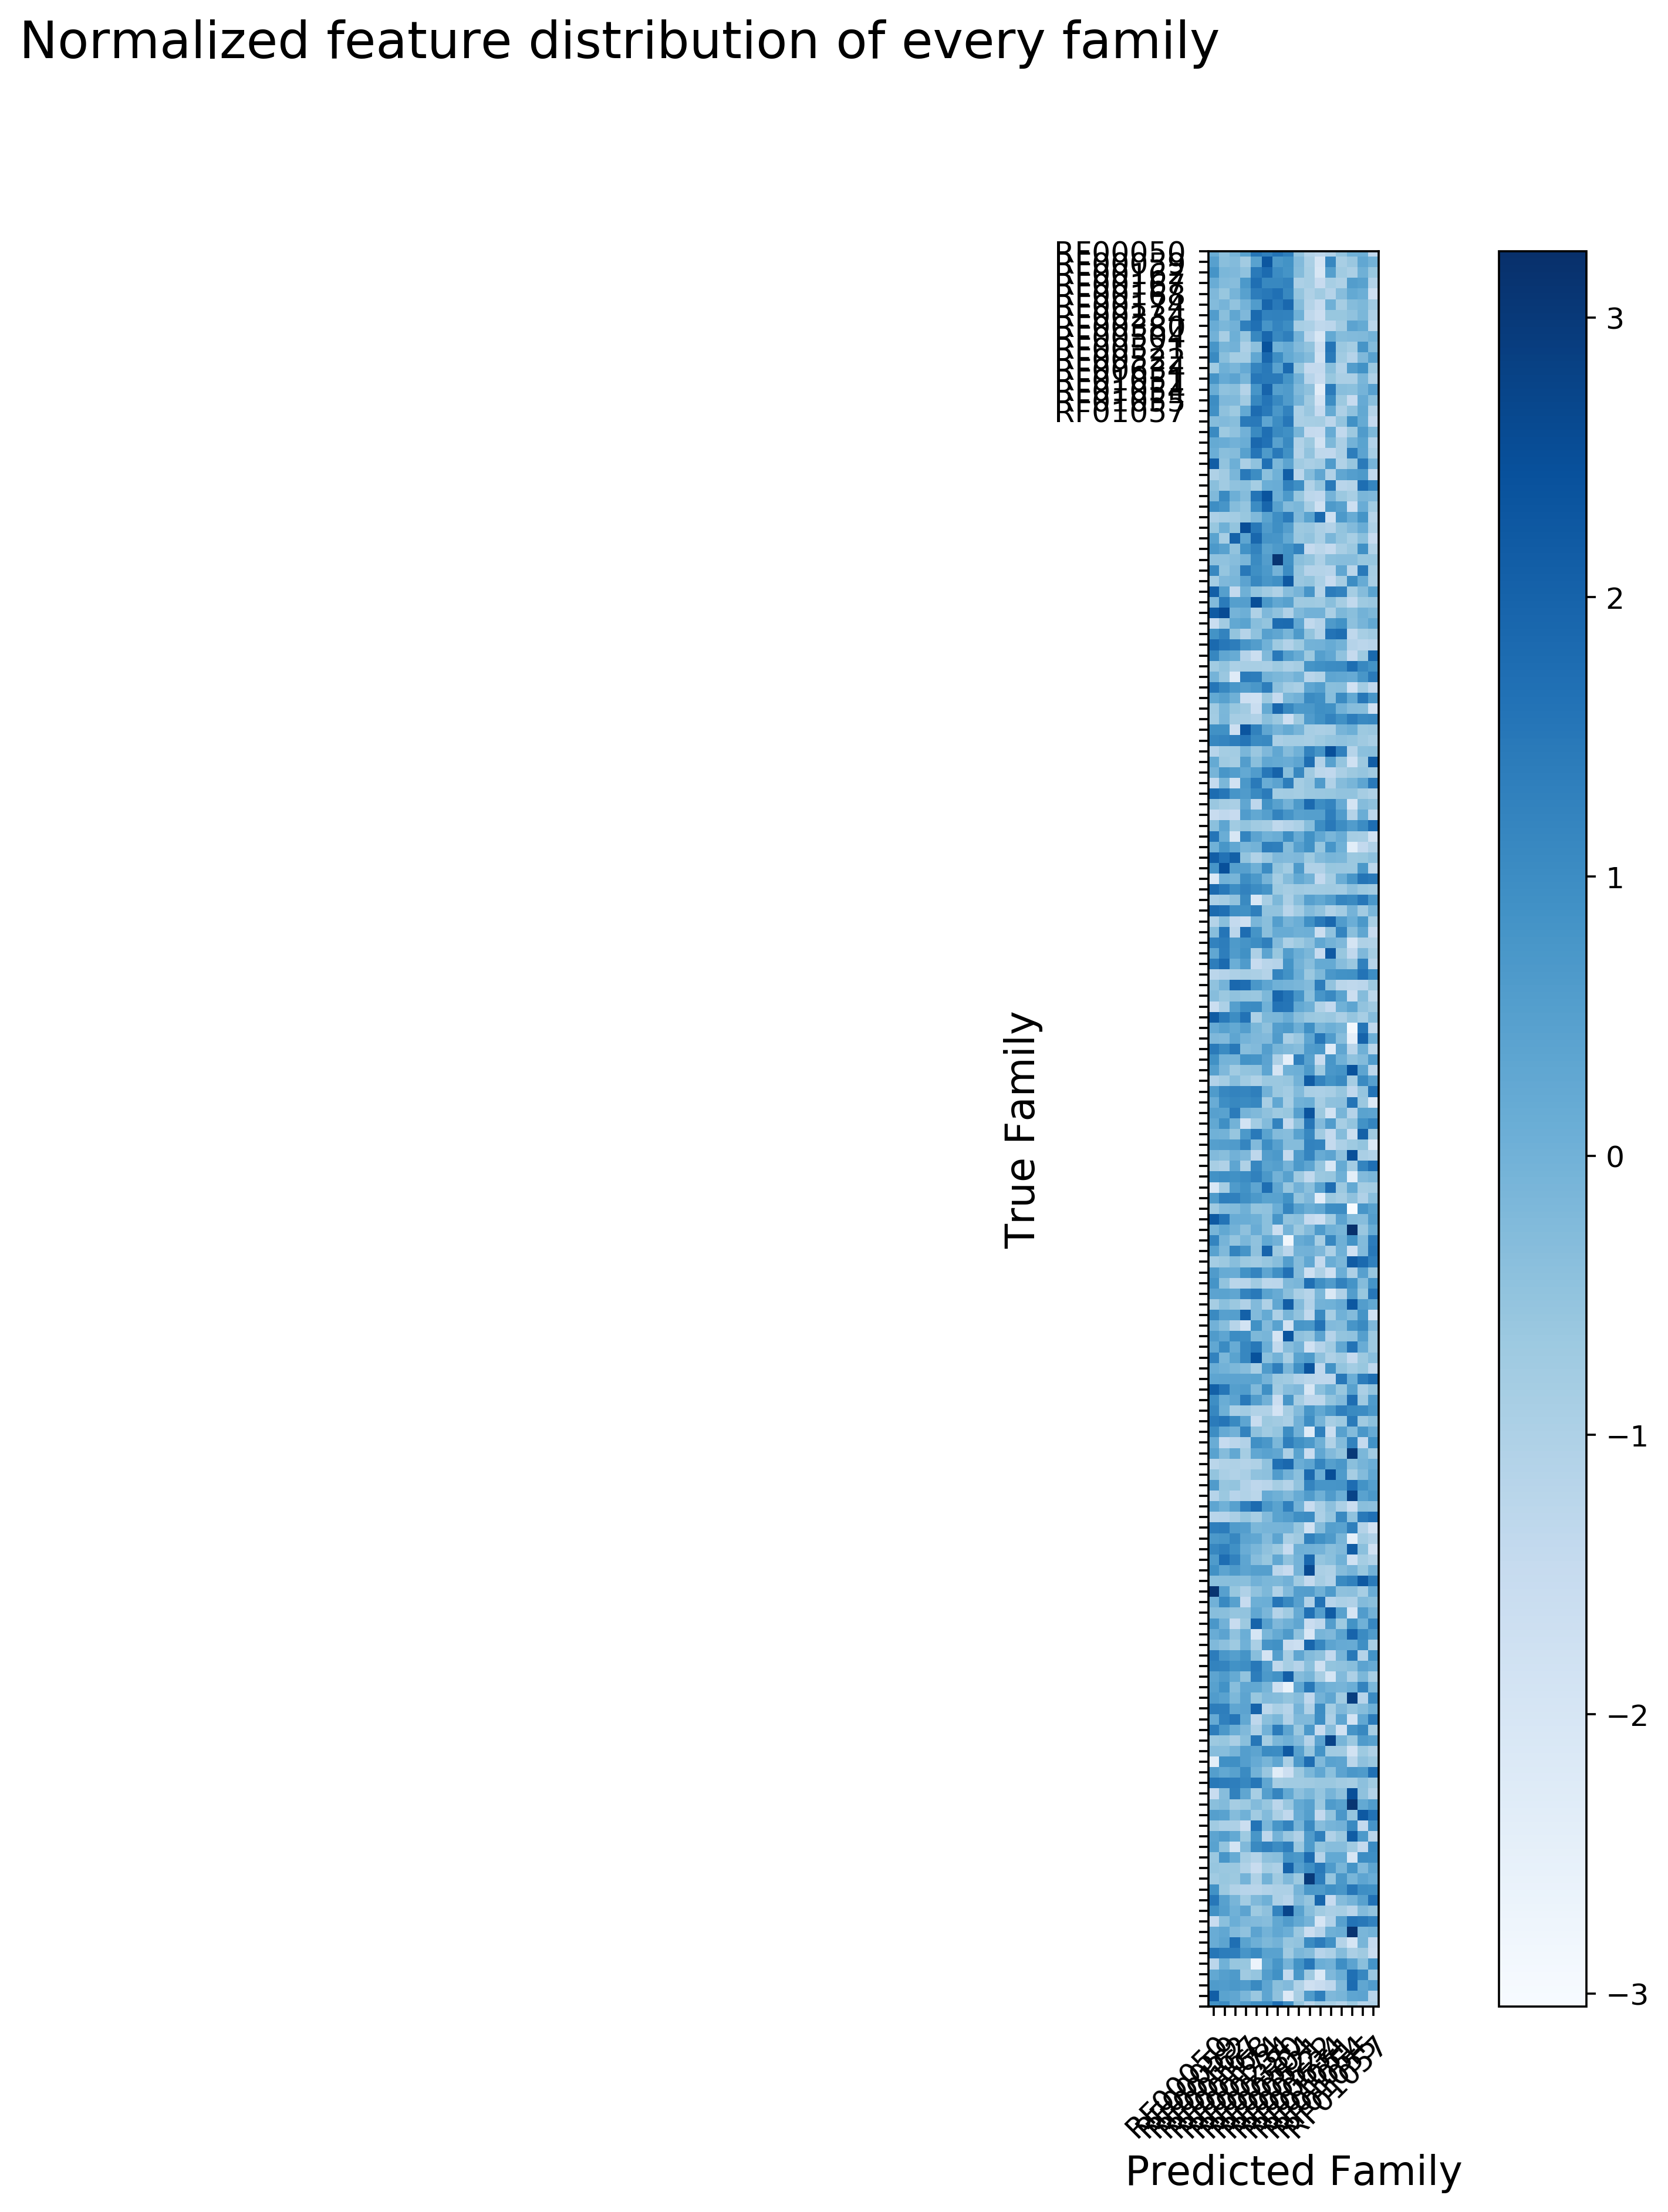

In [80]:
plot_feature_distribution_heatmap(heat_norm, label)

In [79]:
type(heat_norm)

pandas.core.frame.DataFrame

In [44]:
pltROC(knn, svm, random, gb, mlp, nb, balance = 'balanced', x_train, y_trian, x_test, y_test)
pltROC(knn, svm, random, gb, mlp, nb, balance = 'imbalanced', x_train, y_trian, x_test, y_test)

{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521': 1090, 'RF00522': 770, 'RF00634': 1490, 'RF01051': 1416, 'RF01054': 320, 'RF01055': 1105, 'RF01057': 1390}


## KNN model test

knn
----------------------------------------------------------------
6
{'fit_time': array([2.73345852, 2.74408722, 2.72438288, 2.71913028, 2.72985744,
       2.71405077, 2.73205566, 2.76732969, 2.77149153, 2.78080273]), 'score_time': array([11.64449716, 11.65879059, 11.33879137, 11.74753881, 11.52937675,
       11.47886443, 11.62336445, 11.27583838, 11.42518258, 11.64675784]), 'test_acc': array([0.7190518 , 0.69339207, 0.73015873, 0.68165785, 0.71075838,
       0.72663139, 0.70583039, 0.69938108, 0.70442478, 0.68355556]), 'test_prec_macro': array([0.66860652, 0.59492689, 0.63100403, 0.60542931, 0.61968314,
       0.62862913, 0.59554669, 0.58697427, 0.61258745, 0.58500578]), 'test_rec_macro': array([0.83786398, 0.74763462, 0.81305477, 0.80039324, 0.81401494,
       0.8127828 , 0.76763498, 0.77577909, 0.79530861, 0.75766542]), 'test_f1_macro': array([0.71824531, 0.63671461, 0.68394838, 0.65684749, 0.67639998,
       0.68108817, 0.64539227, 0.63990675, 0.66265878, 0.62896309])}
8
{'fit_ti

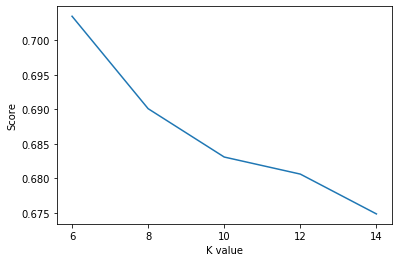

Maximum KNN Acuracy Score is 70.35%
f1 score of knn: 0.654
Classification report of knn: 
              precision    recall  f1-score   support

     RF00050      0.634     0.827     0.718       375
     RF00059      0.935     0.579     0.715      1097
     RF00162      0.450     0.751     0.563       362
     RF00167      0.651     0.860     0.741       243
     RF00168      0.332     0.720     0.454       100
     RF00174      0.978     0.659     0.787      1270
     RF00234      0.319     0.613     0.420        75
     RF00380      0.458     0.909     0.609        66
     RF00504      0.829     0.699     0.758       644
     RF00521      0.581     0.931     0.715        58
     RF00522      0.950     0.974     0.962        39
     RF00634      0.476     0.881     0.618        67
     RF01051      0.823     0.817     0.820       312
     RF01054      0.333     1.000     0.500         7
     RF01055      0.349     0.817     0.489        82
     RF01057      0.495     0.763     0.600  

In [72]:
print('knn')
print('----------------------------------------------------------------')
knn = KNN(x_train, y_train, x_test, y_test,dict)

knn_im
----------------------------------------------------------------
6
{'fit_time': array([0.07514286, 0.07971048, 0.08090806, 0.0779736 , 0.08159637,
       0.08159661, 0.08190465, 0.08431983, 0.08460593, 0.0936656 ]), 'score_time': array([4.82805753, 5.26329184, 5.08329034, 5.26224566, 5.03232789,
       5.16725016, 4.94197726, 4.95740128, 5.08509636, 5.02408361]), 'test_acc': array([0.83143108, 0.81674009, 0.83862434, 0.81746032, 0.81128748,
       0.8324515 , 0.81095406, 0.80990274, 0.81504425, 0.8       ]), 'test_prec_macro': array([0.85935556, 0.81291855, 0.82610953, 0.77169469, 0.80050006,
       0.80628458, 0.76041979, 0.71774801, 0.74516598, 0.78500353]), 'test_rec_macro': array([0.76354931, 0.71641427, 0.73325533, 0.71013969, 0.71270108,
       0.73698476, 0.71019553, 0.69067241, 0.70238021, 0.71050551]), 'test_f1_macro': array([0.79648701, 0.74423303, 0.76022256, 0.73147914, 0.73637878,
       0.76421377, 0.72689014, 0.69595033, 0.71405421, 0.73757279])}
8
{'fit_time': ar

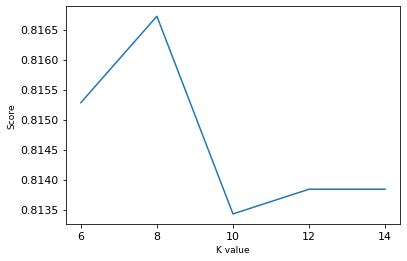

Maximum KNN_im Acuracy Score is 81.67%
f1 score of knn_im: 0.743
Classification report of knn_im: 
              precision    recall  f1-score   support

     RF00050      0.722     0.789     0.754       375
     RF00059      0.819     0.887     0.852      1097
     RF00162      0.676     0.674     0.675       362
     RF00167      0.844     0.823     0.833       243
     RF00168      0.690     0.600     0.642       100
     RF00174      0.889     0.898     0.894      1270
     RF00234      0.589     0.440     0.504        75
     RF00380      0.774     0.727     0.750        66
     RF00504      0.797     0.803     0.800       644
     RF00521      0.754     0.897     0.819        58
     RF00522      0.949     0.949     0.949        39
     RF00634      0.810     0.761     0.785        67
     RF01051      0.908     0.731     0.810       312
     RF01054      0.750     0.429     0.545         7
     RF01055      0.746     0.537     0.624        82
     RF01057      0.842     0.542   

In [81]:
print('knn_im')
print('----------------------------------------------------------------')
knn_im = KNN_im(x_train, y_train, x_test, y_test)

## SVM model test

In [82]:
print('svm')
print('----------------------------------------------------------------')
svm = svm(x_train, y_train, x_test, y_test, 'not majority')

svm
----------------------------------------------------------------
poly
{'fit_time': array([198.27205706, 200.12935495, 202.22198629, 200.52734828,
       198.4014647 , 201.52290535, 195.59675169, 202.29709888,
       201.98560095, 199.42761517]), 'score_time': array([6.89997721, 6.65764689, 6.44739008, 6.60445237, 7.10512018,
       6.51049256, 6.87055492, 6.45150971, 6.577878  , 6.88916802]), 'test_acc': array([0.86742757, 0.85814978, 0.8712522 , 0.85626102, 0.85097002,
       0.87213404, 0.86042403, 0.87002653, 0.85663717, 0.86311111]), 'test_prec_macro': array([0.84666507, 0.82380112, 0.82438764, 0.83621526, 0.83691466,
       0.83740981, 0.80060815, 0.85983804, 0.82220813, 0.85025662]), 'test_rec_macro': array([0.82154714, 0.78162449, 0.81300348, 0.79843064, 0.814877  ,
       0.84368794, 0.79798657, 0.81029399, 0.82114697, 0.80115685]), 'test_f1_macro': array([0.83009329, 0.79840683, 0.80909657, 0.81244475, 0.81950384,
       0.83687182, 0.79532612, 0.82783736, 0.81645269, 0.81

/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


rbf
{'fit_time': array([605.93344307, 594.82903552, 605.06895638, 610.9368484 ,
       610.28659034, 593.12004924, 596.81170654, 611.29398823,
       598.34107018, 607.69408989]), 'score_time': array([14.48531485, 14.81122708, 14.5390029 , 13.86177921, 13.99707437,
       14.95502567, 14.74567127, 13.77629566, 14.5501585 , 14.03348732]), 'test_acc': array([0.87971905, 0.87753304, 0.91534392, 0.88624339, 0.89506173,
       0.89241623, 0.88427562, 0.87886826, 0.89026549, 0.87822222]), 'test_prec_macro': array([0.90163704, 0.87660107, 0.9074251 , 0.89188708, 0.90127886,
       0.85436973, 0.8767722 , 0.82090475, 0.87421977, 0.85724124]), 'test_rec_macro': array([0.84686319, 0.77401156, 0.84462608, 0.87575818, 0.84588159,
       0.80718208, 0.80119191, 0.78001293, 0.82937821, 0.79494014]), 'test_f1_macro': array([0.86733442, 0.80776948, 0.87096408, 0.88188234, 0.86756711,
       0.82515721, 0.82975957, 0.7950862 , 0.84610096, 0.81887689])}


/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Maximum kernel Score is 88.18%
f1 score of svm: 0.833
Classification report of svm: 
              precision    recall  f1-score   support

     RF00050      0.865     0.835     0.849       375
     RF00059      0.902     0.938     0.920      1097
     RF00162      0.821     0.785     0.802       362
     RF00167      0.876     0.868     0.872       243
     RF00168      0.771     0.640     0.699       100
     RF00174      0.880     0.934     0.906      1270
     RF00234      0.672     0.573     0.619        75
     RF00380      0.864     0.773     0.816        66
     RF00504      0.899     0.880     0.889       644
     RF00521      0.947     0.931     0.939        58
     RF00522      0.974     0.949     0.961        39
     RF00634      0.871     0.806     0.837        67
     RF01051      0.949     0.904     0.926       312
     RF01054      1.000     0.571     0.727         7
     RF01055      0.838     0.695     0.760        82
     RF01057      0.836     0.780     0.807       

svm_im
----------------------------------------------------------------
poly
{'fit_time': array([62.34554195, 62.37236023, 61.56213999, 61.39873409, 55.10120821,
       62.43764257, 60.71524358, 60.45739198, 61.42514968, 61.51646018]), 'score_time': array([3.81181693, 3.80466747, 3.84220862, 3.90084553, 3.87245369,
       3.8052125 , 3.82513833, 3.88864636, 3.87056041, 3.81642485]), 'test_acc': array([0.88147498, 0.85022026, 0.88447972, 0.85978836, 0.86155203,
       0.88095238, 0.86130742, 0.87002653, 0.86548673, 0.87022222]), 'test_prec_macro': array([0.8616323 , 0.82160946, 0.85952289, 0.83973696, 0.8458533 ,
       0.87067654, 0.84829424, 0.85051168, 0.83635036, 0.8494602 ]), 'test_rec_macro': array([0.82824875, 0.77952495, 0.84534386, 0.82178104, 0.83934034,
       0.825419  , 0.79223169, 0.80610614, 0.84794269, 0.81214261]), 'test_f1_macro': array([0.84183169, 0.79410402, 0.8488024 , 0.82504898, 0.83825997,
       0.8434059 , 0.80492687, 0.82236905, 0.83888863, 0.82593306])}


/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


rbf
{'fit_time': array([178.09298992, 180.86810994, 181.19644833, 179.98172259,
       174.81823921, 181.53301406, 179.68264294, 180.43529487,
       178.22234845, 175.88987756]), 'score_time': array([8.08172631, 8.01467848, 7.98966146, 8.0327034 , 8.1099081 ,
       7.91041589, 8.05211401, 8.01771259, 8.02967191, 8.05638742]), 'test_acc': array([0.87357331, 0.86255507, 0.90652557, 0.87477954, 0.87830688,
       0.88095238, 0.87102473, 0.87002653, 0.87168142, 0.872     ]), 'test_prec_macro': array([0.90470181, 0.87831473, 0.9033219 , 0.8858068 , 0.9025756 ,
       0.85447007, 0.86567977, 0.79361311, 0.78715421, 0.8746877 ]), 'test_rec_macro': array([0.79321791, 0.75186042, 0.82708011, 0.8009192 , 0.79377024,
       0.77273736, 0.7778813 , 0.73890217, 0.75097996, 0.78207653]), 'test_f1_macro': array([0.83451592, 0.79419178, 0.85805014, 0.82949801, 0.83330487,
       0.80759646, 0.81397279, 0.75778164, 0.76544253, 0.81746609])}


/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


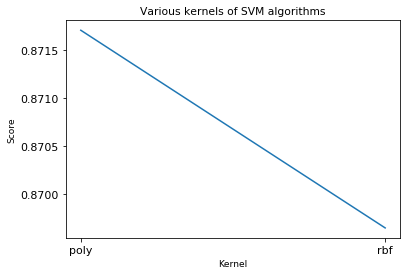

Maximum kernel Score is 87.17%
f1 score of svm: 0.801
Classification report of svm: 
              precision    recall  f1-score   support

     RF00050      0.859     0.797     0.827       375
     RF00059      0.891     0.935     0.913      1097
     RF00162      0.817     0.754     0.784       362
     RF00167      0.904     0.856     0.879       243
     RF00168      0.811     0.600     0.690       100
     RF00174      0.853     0.943     0.896      1270
     RF00234      0.648     0.467     0.543        75
     RF00380      0.842     0.727     0.780        66
     RF00504      0.876     0.877     0.877       644
     RF00521      0.898     0.914     0.906        58
     RF00522      0.974     0.949     0.961        39
     RF00634      0.909     0.746     0.820        67
     RF01051      0.943     0.897     0.920       312
     RF01054      1.000     0.429     0.600         7
     RF01055      0.820     0.610     0.699        82
     RF01057      0.826     0.644     0.724       

In [83]:
print('svm_im')
print('----------------------------------------------------------------')
svm_im = svm_im(x_train, y_train, x_test, y_test)

## Random forest test

In [84]:
print('random forest')
print('----------------------------------------------------------------')
random = random_forest(x_train, y_train, x_test, y_test, dict)

random forest
----------------------------------------------------------------
Test score: 0.85
f1 score of random_forest: 0.801
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.822     0.800     0.811       375
     RF00059      0.847     0.917     0.881      1097
     RF00162      0.765     0.738     0.751       362
     RF00167      0.835     0.790     0.812       243
     RF00168      0.635     0.660     0.647       100
     RF00174      0.907     0.887     0.897      1270
     RF00234      0.641     0.787     0.707        75
     RF00380      0.847     0.758     0.800        66
     RF00504      0.875     0.812     0.842       644
     RF00521      0.962     0.879     0.919        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.775     0.821     0.797        67
     RF01051      0.851     0.859     0.855       312
     RF01054      1.000     0.571     0.727         7
     RF01055      0

In [85]:
print('random_forest_im')
print('----------------------------------------------------------------')
random_im = random_forest_im(x_train, y_train, x_test, y_test)

random_forest_im
----------------------------------------------------------------
Test score: 0.83
f1 score of random_forest: 0.751
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.812     0.773     0.792       375
     RF00059      0.816     0.932     0.870      1097
     RF00162      0.803     0.677     0.735       362
     RF00167      0.838     0.786     0.811       243
     RF00168      0.710     0.490     0.580       100
     RF00174      0.862     0.918     0.889      1270
     RF00234      0.755     0.533     0.625        75
     RF00380      0.919     0.515     0.660        66
     RF00504      0.819     0.873     0.845       644
     RF00521      0.975     0.672     0.796        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.860     0.642     0.735        67
     RF01051      0.856     0.821     0.838       312
     RF01054      1.000     0.429     0.600         7
     RF01055    

In [86]:
print('random forest not majority')
print('----------------------------------------------------------------')
random_test1 = random_forest(x_train, y_train, x_test, y_test, 'not majority')

random forest not majority
----------------------------------------------------------------
Test score: 0.86
f1 score of random_forest: 0.813
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.813     0.824     0.819       375
     RF00059      0.873     0.912     0.892      1097
     RF00162      0.770     0.749     0.759       362
     RF00167      0.843     0.798     0.820       243
     RF00168      0.626     0.770     0.691       100
     RF00174      0.927     0.876     0.901      1270
     RF00234      0.690     0.800     0.741        75
     RF00380      0.850     0.773     0.810        66
     RF00504      0.865     0.859     0.862       644
     RF00521      0.939     0.793     0.860        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.779     0.791     0.785        67
     RF01051      0.853     0.872     0.862       312
     RF01054      1.000     0.571     0.727         7
     R

In [87]:
print('random forest_classweight')
print('----------------------------------------------------------------')
random_test2 = random_forest(x_train, y_train, x_test, y_test, dict, 'balanced')

random forest_classweight
----------------------------------------------------------------
Test score: 0.85
f1 score of random_forest: 0.800
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.818     0.816     0.817       375
     RF00059      0.859     0.922     0.889      1097
     RF00162      0.777     0.724     0.750       362
     RF00167      0.828     0.815     0.822       243
     RF00168      0.674     0.640     0.656       100
     RF00174      0.905     0.891     0.898      1270
     RF00234      0.663     0.733     0.696        75
     RF00380      0.823     0.773     0.797        66
     RF00504      0.873     0.821     0.846       644
     RF00521      0.942     0.845     0.891        58
     RF00522      0.950     0.974     0.962        39
     RF00634      0.786     0.821     0.803        67
     RF01051      0.855     0.869     0.862       312
     RF01054      0.800     0.571     0.667         7
     RF

In [88]:
print('random forest_im_classweight')
print('----------------------------------------------------------------')
random_test3 = random_forest_im(x_train, y_train, x_test, y_test, 'balanced')

random forest_im_classweight
----------------------------------------------------------------
Test score: 0.83
f1 score of random_forest: 0.741
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.845     0.771     0.806       375
     RF00059      0.807     0.940     0.869      1097
     RF00162      0.848     0.649     0.736       362
     RF00167      0.845     0.741     0.789       243
     RF00168      0.700     0.490     0.576       100
     RF00174      0.841     0.907     0.873      1270
     RF00234      0.788     0.547     0.646        75
     RF00380      0.897     0.530     0.667        66
     RF00504      0.836     0.857     0.847       644
     RF00521      0.935     0.741     0.827        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.870     0.701     0.777        67
     RF01051      0.866     0.846     0.856       312
     RF01054      1.000     0.143     0.250         7
    

## Gradient Boosting

In [89]:
gb = gradient_boosting(x_train, y_train, x_test, y_test, dict)

Accuracy on test set:0.821
f1 score of gb: 0.724
Classification report of gb: 
              precision    recall  f1-score   support

     RF00050      0.792     0.763     0.777       375
     RF00059      0.840     0.900     0.869      1097
     RF00162      0.733     0.743     0.738       362
     RF00167      0.811     0.761     0.786       243
     RF00168      0.607     0.510     0.554       100
     RF00174      0.899     0.883     0.891      1270
     RF00234      0.539     0.733     0.621        75
     RF00380      0.578     0.561     0.569        66
     RF00504      0.850     0.817     0.833       644
     RF00521      0.857     0.621     0.720        58
     RF00522      0.947     0.923     0.935        39
     RF00634      0.765     0.776     0.770        67
     RF01051      0.817     0.814     0.815       312
     RF01054      0.444     0.571     0.500         7
     RF01055      0.617     0.610     0.613        82
     RF01057      0.593     0.593     0.593        59

 

In [11]:
gb_im = gradient_boosting_im(x_train, y_train, x_test, y_test)

Accuracy on train set:0.803
Accuracy on test set:0.803
f1 score of gb_im: 0.663
Classification report of gb_im: 
              precision    recall  f1-score   support

     RF00050      0.801     0.739     0.768       375
     RF00059      0.808     0.912     0.857      1097
     RF00162      0.745     0.677     0.709       362
     RF00167      0.806     0.716     0.758       243
     RF00168      0.582     0.390     0.467       100
     RF00174      0.851     0.906     0.877      1270
     RF00234      0.630     0.453     0.527        75
     RF00380      0.737     0.424     0.538        66
     RF00504      0.784     0.856     0.818       644
     RF00521      0.795     0.534     0.639        58
     RF00522      0.971     0.846     0.904        39
     RF00634      0.765     0.582     0.661        67
     RF01051      0.808     0.753     0.779       312
     RF01054      0.182     0.286     0.222         7
     RF01055      0.774     0.500     0.607        82
     RF01057      0.62

## MLP

In [95]:
mlp = mlp(x_train, y_train, x_test, y_test, dict)

Accuracy of mlp model is 0.875
['RF00380' 'RF00059' 'RF00162' ... 'RF00162' 'RF00162' 'RF00504']
0.875
f1 score of mlp: 0.805
Classification report of mlp: 
              precision    recall  f1-score   support

     RF00050      0.880     0.861     0.871       375
     RF00059      0.903     0.902     0.903      1097
     RF00162      0.818     0.818     0.818       362
     RF00167      0.829     0.798     0.813       243
     RF00168      0.616     0.610     0.613       100
     RF00174      0.907     0.928     0.917      1270
     RF00234      0.746     0.667     0.704        75
     RF00380      0.689     0.636     0.661        66
     RF00504      0.890     0.905     0.898       644
     RF00521      0.900     0.776     0.833        58
     RF00522      0.971     0.846     0.904        39
     RF00634      0.855     0.791     0.822        67
     RF01051      0.870     0.920     0.894       312
     RF01054      0.667     0.571     0.615         7
     RF01055      0.822     0.73

In [14]:
mlp_im = mlp_im(x_train, y_train, x_test, y_test)

Accuracy of mlp_im imbalance model is 0.866
['RF00174' 'RF00162' 'RF00162' ... 'RF00162' 'RF00162' 'RF00504']
0.8661449752883031
f1 score of mlp_im: 0.772
Classification report of mlp_im: 
              precision    recall  f1-score   support

     RF00050      0.881     0.869     0.875       375
     RF00059      0.904     0.918     0.911      1097
     RF00162      0.794     0.787     0.791       362
     RF00167      0.793     0.757     0.775       243
     RF00168      0.561     0.600     0.580       100
     RF00174      0.924     0.921     0.923      1270
     RF00234      0.694     0.667     0.680        75
     RF00380      0.578     0.561     0.569        66
     RF00504      0.897     0.902     0.899       644
     RF00521      0.691     0.655     0.673        58
     RF00522      0.872     0.872     0.872        39
     RF00634      0.720     0.806     0.761        67
     RF01051      0.858     0.875     0.867       312
     RF01054      0.800     0.571     0.667         7


In [ ]:
print_report('mlp_im_test', mlp_im, x_train, y_train)

## NB test

In [93]:
print('nb')
print('-------------------------------------------------------')
nb = naive_bayes(x_train, y_train, x_test, y_test, dict)

nb
-------------------------------------------------------
Accuracy of Naive Bayes: 63.55%
f1 score of nb: 0.300
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.657     0.491     0.562       375
     RF00059      0.626     0.787     0.697      1097
     RF00162      0.599     0.367     0.455       362
     RF00167      0.544     0.280     0.370       243
     RF00168      0.276     0.160     0.203       100
     RF00174      0.715     0.852     0.778      1270
     RF00234      0.188     0.040     0.066        75
     RF00380      0.000     0.000     0.000        66
     RF00504      0.555     0.803     0.656       644
     RF00521      0.500     0.034     0.065        58
     RF00522      1.000     0.026     0.050        39
     RF00634      1.000     0.045     0.086        67
     RF01051      0.676     0.663     0.670       312
     RF01054      0.000     0.000     0.000         7
     RF01055      0.467     0.085     0.144   

/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
print('nb_im')
print('-------------------------------------------------------')
nb_im = naive_bayes_im(x_train, y_train, x_test, y_test)

nb_im
-------------------------------------------------------
Accuracy of Naive Bayes: 54.86%
f1 score of nb: 0.508
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.748     0.659     0.701       375
     RF00059      0.864     0.600     0.708      1097
     RF00162      0.614     0.492     0.546       362
     RF00167      0.587     0.416     0.487       243
     RF00168      0.168     0.850     0.281       100
     RF00174      0.926     0.441     0.597      1270
     RF00234      0.107     0.747     0.187        75
     RF00380      0.609     0.212     0.315        66
     RF00504      0.780     0.562     0.653       644
     RF00521      0.313     0.897     0.464        58
     RF00522      0.900     0.923     0.911        39
     RF00634      0.377     0.776     0.507        67
     RF01051      0.794     0.580     0.670       312
     RF01054      0.009     0.571     0.017         7
     RF01055      0.667     0.537     0.595

## Three methods comparison

In [168]:
best = make_pipeline(SMOTE(random_state = 5), KNeighborsClassifier(n_neighbors=10))
scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores)
best.fit(x_train, y_train)
best.score(x_test, y_test)
best_pred = best.predict(x_test)
# f1 score
print("f1 score of best: {:.2f}".format(f1_score(y_test,best_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best: \n{}".format(classification_report(y_test, best_pred,
                                        target_names= label)))
best_proba = best.predict_proba(x_test)

{'fit_time': array([1.36815619, 1.38522267, 1.27516413, 1.46671844, 1.39341235]), 'score_time': array([65.77883387, 66.15830994, 64.95893312, 67.77423406, 66.04027724]), 'test_precision_macro': array([0.45819163, 0.48098308, 0.45682151, 0.47233651, 0.47222897]), 'test_recall_macro': array([0.69405591, 0.69335485, 0.67254681, 0.7193012 , 0.69062105]), 'test_f1_macro': array([0.46983322, 0.4947362 , 0.46601983, 0.49063489, 0.4851479 ])}
f1 score of best: 0.50
Classification report of best: 
              precision    recall  f1-score   support

     RF00050       0.62      0.79      0.69       359
     RF00059       0.95      0.43      0.59      1083
     RF00162       0.44      0.80      0.57       365
     RF00167       0.54      0.73      0.62       244
     RF00168       0.14      0.66      0.23        88
     RF00174       1.00      0.33      0.49      1277
     RF00234       0.25      0.71      0.37        90
     RF00380       0.20      0.79      0.32        63
     RF00504       

In [170]:
best2 = KNeighborsClassifier(n_neighbors=16)
scores2 = cross_validate(best2, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores2)
best2.fit(x_train, y_train)
best2.score(x_test, y_test)
best2_pred = best2.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best2_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best2: \n{}".format(classification_report(y_test, best2_pred,
                                        target_names= label)))
best2_proba = best2.predict_proba(x_test)

{'fit_time': array([0.04368973, 0.04368138, 0.04063821, 0.04307175, 0.04468369]), 'score_time': array([11.63832211, 11.69619298, 12.09875536, 11.89288187, 11.96761632]), 'test_precision_macro': array([0.76222982, 0.77800996, 0.71748333, 0.7782801 , 0.79469287]), 'test_recall_macro': array([0.51248768, 0.5246983 , 0.50299728, 0.52320519, 0.49453976]), 'test_f1_macro': array([0.5736022 , 0.57565019, 0.55515465, 0.5859372 , 0.55578544])}
f1 score of best3: 0.60
Classification report of best2: 
              precision    recall  f1-score   support

     RF00050       0.83      0.78      0.81       359
     RF00059       0.79      0.92      0.85      1083
     RF00162       0.65      0.74      0.69       365
     RF00167       0.86      0.59      0.70       244
     RF00168       0.57      0.48      0.52        88
     RF00174       0.88      0.87      0.88      1277
     RF00234       0.80      0.27      0.40        90
     RF00380       0.79      0.48      0.59        63
     RF00504     

In [171]:
over_samples_train = SMOTEENN(random_state=5, n_jobs=5)
x_train_s, y_train_s = over_samples_train.fit_sample(x_train, y_train)
best3 = KNeighborsClassifier(n_neighbors=16)
scores3 = cross_validate(best3, x_train_s, y_train_s, scoring = scoring, cv = 5, n_jobs=10)
print(scores3)
best3.fit(x_train_s, y_train_s)
best3.score(x_test, y_test)

best3_pred = best3.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best3_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best3: \n{}".format(classification_report(y_test, best3_pred,
                                        target_names= label)))
best3_proba = best3.predict_proba(x_test)

{'fit_time': array([0.22312522, 0.29851818, 0.29342937, 0.18135238, 0.28857732]), 'score_time': array([168.14797163, 165.46073842, 166.19052601, 162.7279706 ,
       163.33171201]), 'test_precision_macro': array([0.95304545, 0.96063604, 0.95937588, 0.9568318 , 0.95625031]), 'test_recall_macro': array([0.91273627, 0.92393875, 0.91939974, 0.90468659, 0.90314451]), 'test_f1_macro': array([0.92442428, 0.93549652, 0.93110554, 0.91621002, 0.91123336])}
f1 score of best3: 0.46
Classification report of best3: 
              precision    recall  f1-score   support

     RF00050       0.55      0.79      0.65       359
     RF00059       0.98      0.26      0.41      1083
     RF00162       0.40      0.80      0.53       365
     RF00167       0.50      0.72      0.59       244
     RF00168       0.11      0.66      0.19        88
     RF00174       1.00      0.17      0.30      1277
     RF00234       0.24      0.73      0.36        90
     RF00380       0.17      0.78      0.28        63
     

,A,C,G,U,AA,AC,AG,AU,CA,CC,...,GCUGAG,GCCACU,GCCUCC,GCCGAA,GGAAGG,GGAGAG,GGCUGA,GGCGGU,GGGAAG,GGGUGC
Class,,,,,,,,,,,,,,,,,,,,,
RF00522,0.11,0.047619,0.008929,0.072165,0.166667,0.086957,0.028571,0.129032,0.100000,0.064516,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00167,0.23,0.085714,0.169643,0.288660,0.194444,0.130435,0.142857,0.322581,0.066667,0.096774,...,0.0,0.0,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0
RF00174,0.36,0.571429,0.491071,0.257732,0.250000,0.652174,0.342857,0.161290,0.333333,0.677419,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF01055,0.23,0.238095,0.303571,0.185567,0.194444,0.347826,0.200000,0.161290,0.166667,0.258065,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00059,0.22,0.114286,0.178571,0.195876,0.194444,0.217391,0.228571,0.161290,0.133333,0.096774,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF00059,0.23,0.257143,0.258929,0.278351,0.111111,0.391304,0.228571,0.258065,0.200000,0.258065,...,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00167,0.11,0.085714,0.080357,0.154639,0.138889,0.217391,0.000000,0.161290,0.066667,0.161290,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00059,0.10,0.180952,0.267857,0.164948,0.055556,0.130435,0.257143,0.064516,0.066667,0.225806,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.5
